# Is podium


## Dependencies


The dependencies used are as follows


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer

import sys

sys.path.append("..")

from utils.visualization import model_selection
from utils.custom_cvs import VariableTimeSeriesSplit
from utils.custom_scorers import balanced_accuracy_score

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Initialization


We continue with the selection of the model that predicts the podium


In [2]:
df = pd.read_csv("../assets/data/processed/base_model.csv")

instances_per_year = df["raceYear"].value_counts(sort=False)
instances_per_half = (
    np.array(
        list(zip(np.floor(instances_per_year / 2), np.ceil(instances_per_year / 2)))
    )
    .flatten()
    .astype(np.int32)
)

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})

X = pd.read_csv("../assets/data/processed/base_model_X.csv")
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: x["driverRef"] in x["driverRefPodium"], axis=1)

## K-Nearest Neighbors


PI: 0.726 with (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
	20, 21, 22, 23) == ('carNumber', 'circuitAlt', 'circuitCountry', 'circuitLat',
	'circuitLng', 'circuitLocation', 'circuitRef', 'constructorNationality',
	'constructorRef', 'constructorWins', 'driverAgeAtRace', 'driverAgeToday',
	'driverNationality', 'driverNumber', 'driverRef', 'driverWins', 'grandPrix',
	'positionGrid', 'q1', 'q2', 'q3', 'raceRound', 'raceTime', 'raceYear')
SFS: 0.791 with (0, 1, 3, 5, 7, 17) == ('carNumber', 'positionGrid', 'driverNumber',
	'constructorRef', 'raceYear', 'driverWins')
GA: 0.735 with (1, 2, 4, 7, 9, 10, 12, 15, 16, 17, 18, 20, 21, 22) == ('positionGrid',
	'driverRef', 'driverNationality', 'raceYear', 'grandPrix', 'raceTime',
	'circuitLocation', 'circuitLng', 'circuitAlt', 'driverWins', 'constructorWins', 'q2',
	'q3', 'driverAgeToday')


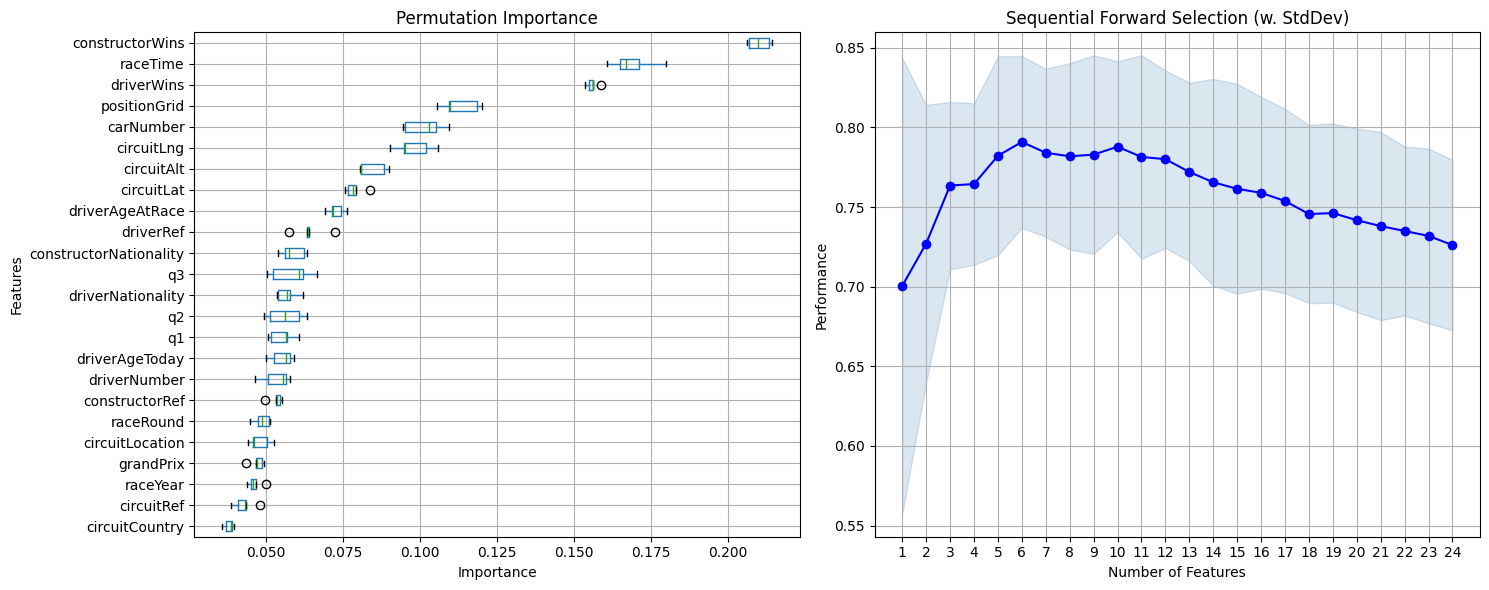

In [3]:
knn = KNeighborsClassifier(n_neighbors=5, metric="cosine", weights="distance")
scoring = make_scorer(balanced_accuracy_score)
model_selection(knn, X, y, tscv, scoring)

## Decision Tree


PI: 0.780 with (1, 5, 17) == ('constructorRef', 'driverWins', 'positionGrid')
SFS: 0.794 with (1, 2, 5, 9, 16) == ('positionGrid', 'driverRef', 'constructorRef',
	'grandPrix', 'circuitAlt')
GA: 0.788 with (1, 2, 5, 8, 11, 12, 19, 21, 22, 23) == ('positionGrid', 'driverRef',
	'constructorRef', 'raceRound', 'circuitRef', 'circuitLocation', 'q1', 'q3',
	'driverAgeToday', 'driverAgeAtRace')


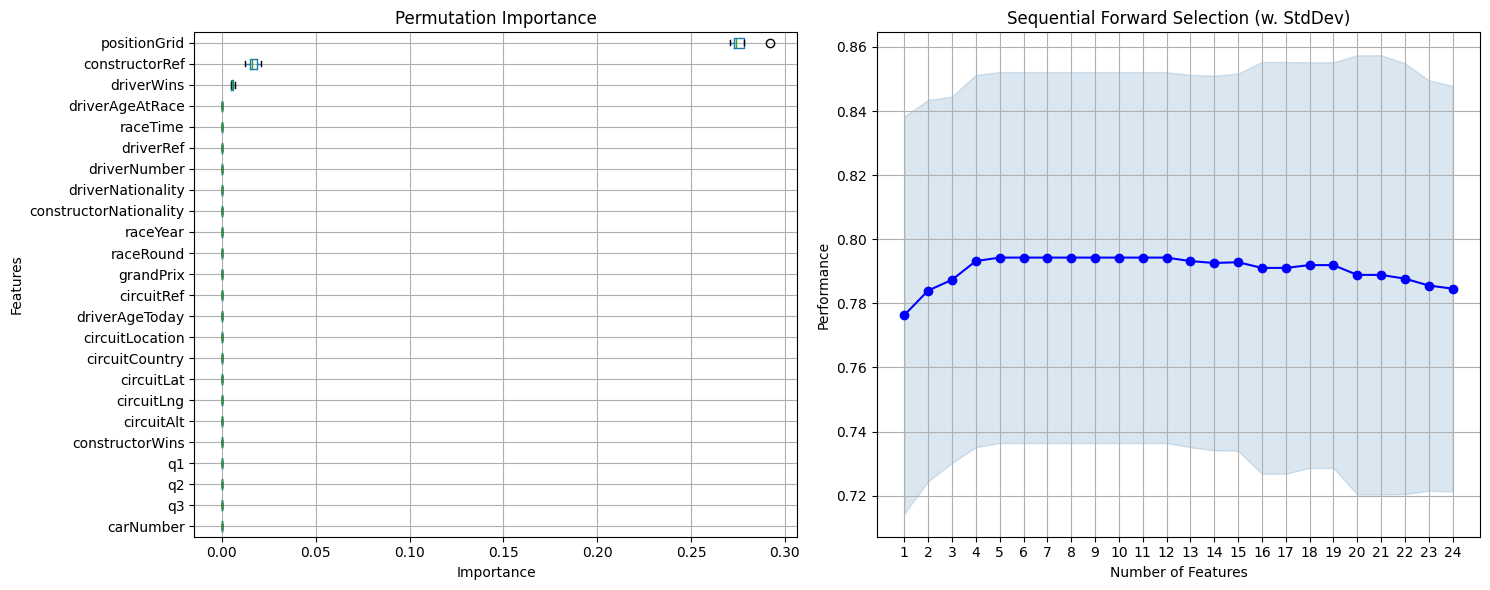

In [4]:
tree = DecisionTreeClassifier(criterion="gini", max_depth=3, splitter="best")
scoring = make_scorer(balanced_accuracy_score)
model_selection(tree, X, y, tscv, scoring)

## Random Forest


PI: 0.771 with (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
	20, 21, 22, 23) == ('carNumber', 'circuitAlt', 'circuitCountry', 'circuitLat',
	'circuitLng', 'circuitLocation', 'circuitRef', 'constructorNationality',
	'constructorRef', 'constructorWins', 'driverAgeAtRace', 'driverAgeToday',
	'driverNationality', 'driverNumber', 'driverRef', 'driverWins', 'grandPrix',
	'positionGrid', 'q1', 'q2', 'q3', 'raceRound', 'raceTime', 'raceYear')
SFS: 0.795 with (1, 2, 7, 14, 17) == ('positionGrid', 'driverRef', 'raceYear',
	'circuitLat', 'driverWins')
GA: 0.788 with (0, 1, 2, 3, 5, 7, 9, 10, 16, 17, 18, 19, 22) == ('carNumber',
	'positionGrid', 'driverRef', 'driverNumber', 'constructorRef', 'raceYear', 'grandPrix',
	'raceTime', 'circuitAlt', 'driverWins', 'constructorWins', 'q1', 'driverAgeToday')


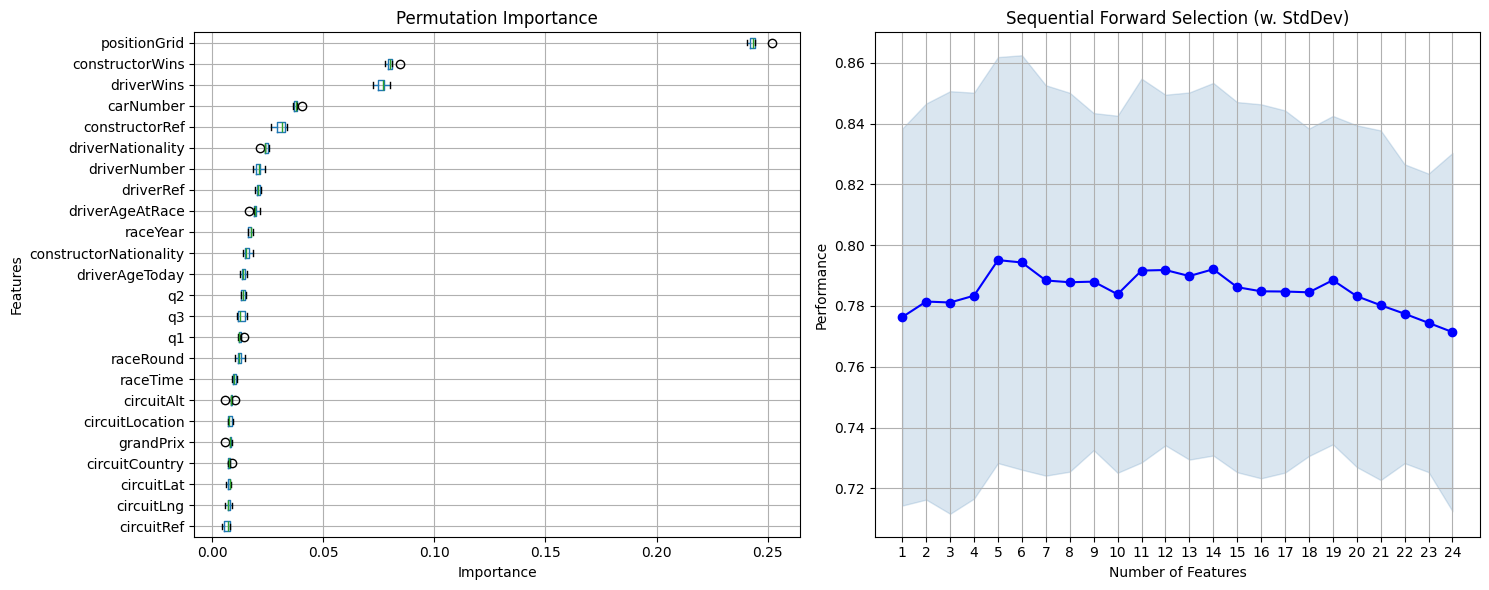

In [5]:
random_forest = RandomForestClassifier(criterion="gini", max_depth=10, n_estimators=200)
scoring = make_scorer(balanced_accuracy_score)
model_selection(random_forest, X, y, tscv, scoring)

## Multilayer Perceptron


PI: 0.799 with (1, 4, 5, 6, 8, 14, 16, 17, 18) == ('circuitAlt', 'circuitLat',
	'constructorNationality', 'constructorRef', 'constructorWins', 'driverNationality',
	'driverWins', 'positionGrid', 'raceRound')
SFS: 0.820 with (1, 2, 3, 4, 7, 8, 9, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23) ==
	('positionGrid', 'driverRef', 'driverNumber', 'driverNationality', 'raceYear',
	'raceRound', 'grandPrix', 'circuitLocation', 'circuitCountry', 'circuitLng',
	'circuitAlt', 'driverWins', 'q1', 'q2', 'q3', 'driverAgeToday', 'driverAgeAtRace')
GA: 0.807 with (1, 5, 7, 8, 9, 15, 16, 17, 22, 23) == ('positionGrid', 'constructorRef',
	'raceYear', 'raceRound', 'grandPrix', 'circuitLng', 'circuitAlt', 'driverWins',
	'driverAgeToday', 'driverAgeAtRace')


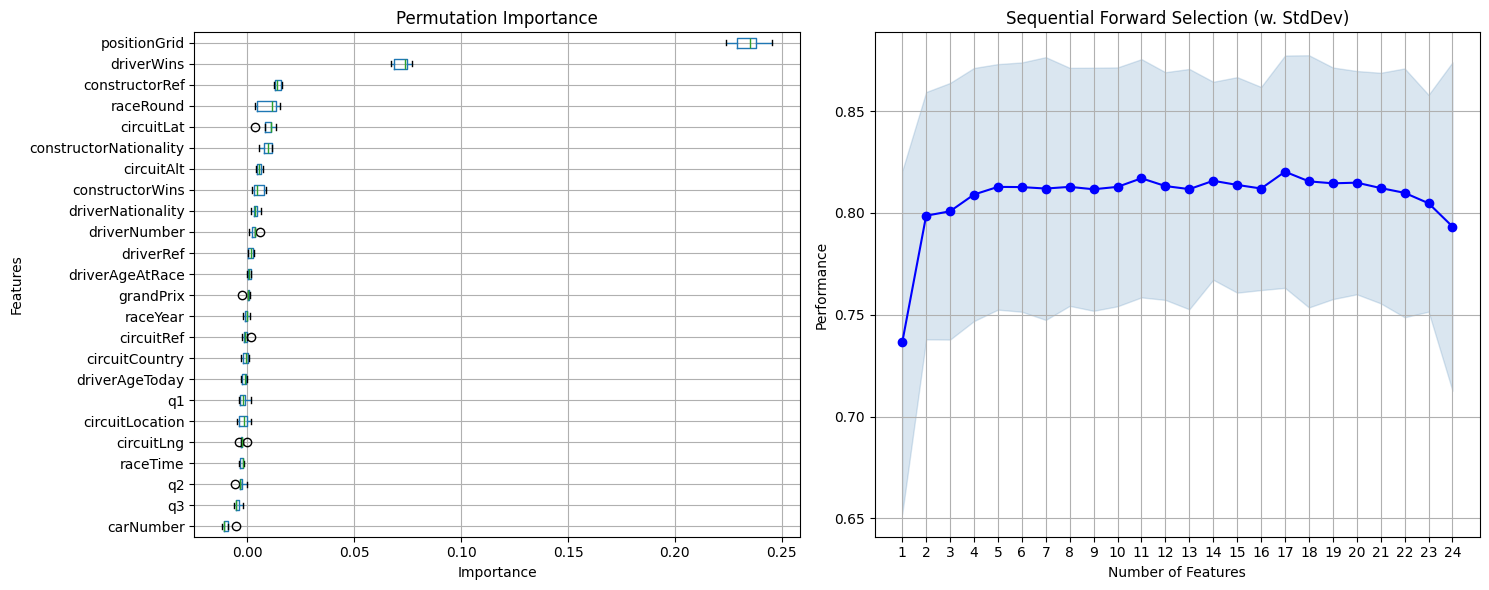

In [6]:
nn = MLPClassifier(activation="logistic", hidden_layer_sizes=(50, 20, 5))
scoring = make_scorer(balanced_accuracy_score)
model_selection(nn, X, y, tscv, scoring)

## Results


Therefore, the selection for each algorithm are as follows

- KNeighborsClassifier: 0.785 with ('carNumber', 'positionGrid', 'driverNumber', 'constructorRef', 'raceYear', 'driverWins')
- DecisionTreeClassifier: 0.794 with ('carNumber', 'positionGrid', 'driverRef', 'constructorRef', 'constructorNationality', 'raceYear', 'raceRound', 'grandPrix', 'raceTime', 'circuitRef', 'circuitLocation', 'circuitCountry', 'circuitLat', 'circuitLng', 'circuitAlt', 'driverWins', 'constructorWins', 'q1', 'q2', 'q3')
- RandomForestClassifier: 0.794 with ('positionGrid', 'driverRef', 'raceYear', 'circuitLng', 'driverWins', 'q1')
- MLPClassifier: 0.815 with ('carNumber', 'positionGrid', 'driverRef', 'driverNumber', 'driverNationality', 'raceYear', 'raceRound', 'circuitRef', 'circuitLocation', 'circuitLat', 'circuitAlt', 'driverWins', 'q1', 'q2', 'q3', 'driverAgeToday', 'driverAgeAtRace')
